In [1]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_models as tfm
import tensorflow_text  # noqa

2024-08-07 18:52:52.954560: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline

In [3]:
%load_ext google.cloud.bigquery

In [4]:
preprocessor_url = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3"

preprocessor_dir = hub.compressed_module_resolver.HttpCompressedFileResolver()(preprocessor_url)
tokenizer = tfm.nlp.layers.FastWordpieceBertTokenizer(
    vocab_file=os.path.join(preprocessor_dir, "assets/vocab.txt"),
    lower_case=True,
)

# Title only

In [4]:
%%bigquery df
with active_listing_titles as (
  select distinct key as listing_id, verticaListings_title as titles 
  from `etsy-data-warehouse-prod.listing_mart.active_listing_vw`
  join `etsy-ml-systems-prod.feature_bank_v2.listing_feature_bank_most_recent`
  on key = listing_id
)
select * 
from active_listing_titles
where titles is not null
and titles != ''
and rand() > 0.9
limit 1000000

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
batch_size = 1024
N_batches = df.shape[0] // batch_size
N_batches

976

In [6]:
curr_titles = df["titles"].values[0:3]
tokens = tokenizer(tf.constant(curr_titles))

In [7]:
curr_titles[1]

'Surfing Lettering Wallart Orange Pink Surfboard Boho Surf Décoration Gift Decorative Art Boarding Wallart Typographic Poster Handpainted'

In [8]:
tokens[1,:,:]

<tf.RaggedTensor [[19967], [25782], [2813, 8445], [4589], [5061], [14175, 6277],
 [8945, 6806], [14175], [11446], [5592], [11584], [2396], [9405],
 [2813, 8445], [5939, 6873, 14773], [13082], [2192, 4502, 18447, 2098]]>

In [9]:
tf.reshape(tokens[1,:,:], [-1])

<tf.Tensor: shape=(26,), dtype=int32, numpy=
array([19967, 25782,  2813,  8445,  4589,  5061, 14175,  6277,  8945,
        6806, 14175, 11446,  5592, 11584,  2396,  9405,  2813,  8445,
        5939,  6873, 14773, 13082,  2192,  4502, 18447,  2098],
      dtype=int32)>

In [10]:
token_lengths_seq = []

for i in tqdm(range(N_batches+1)):
    start_idx = i * batch_size
    end_idx = min((i+1) * batch_size, df.shape[0])
    curr_titles = df["titles"].values[start_idx:end_idx]
    tokens = tokenizer(tf.constant(curr_titles))
    token_lengths = tf.map_fn(
        lambda x: tf.reshape(x, [-1]).shape[0], 
        tokens, 
        fn_output_signature=tf.int32
    )
    token_lengths_seq.extend(token_lengths.numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 977/977 [12:36<00:00,  1.29it/s]


In [14]:
len(token_lengths_seq)

1000000

In [15]:
df["seq_length"] = token_lengths_seq

In [6]:
df.seq_length.describe()

count    1000000.000000
mean          21.555826
std           10.205466
min            1.000000
25%           13.000000
50%           23.000000
75%           29.000000
max          151.000000
Name: seq_length, dtype: float64

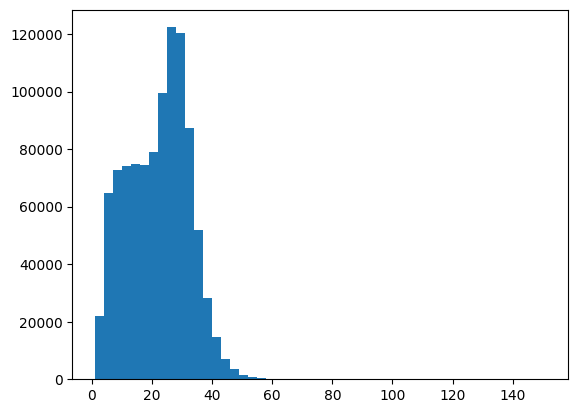

In [7]:
plt.hist(df.seq_length, bins=50)
plt.show()

In [14]:
df[df.seq_length == 29].titles.values[2]

'Rutile Quartz Necklace, Genuine Tourmaline Quartz, Black Clear, Silver Tourmaline Pendant, Tourmaline in Quartz, Gemstone Appeal'